In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 150)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
#To plot figs on jupyter
%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 14,6

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

import luminol

In [76]:
df = pd.read_csv('df.csv')

In [77]:
df = df.drop(columns = ['Unnamed: 0'] )

In [78]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [79]:
df

,Timestamp,OutboundUtilzation (%)
0,2017-10-10 07:01:36,96.2442
1,2017-10-10 07:21:36,99.1131
2,2017-10-10 07:26:36,97.2892
3,2017-10-10 07:31:36,98.0286
4,2017-10-10 07:36:36,99.5263
...,...,...
46321,2018-03-25 23:43:03,65.8425
46322,2018-03-25 23:48:03,56.8811
46323,2018-03-25 23:53:03,43.6352
46324,2018-03-25 23:58:03,48.9415


In [80]:
df = df.set_index('Timestamp')

In [81]:
df = df.resample('1H').mean()

In [82]:
df = df.interpolate(limit=1)

In [83]:
mean = df.mean()
df = df.fillna(value=mean)

# Luminol

In [84]:
import luminol
from luminol import exceptions, utils
from luminol.anomaly_detector import AnomalyDetector
from luminol.algorithms.anomaly_detector_algorithms.all import anomaly_detector_algorithms
from luminol.modules.anomaly import Anomaly
from luminol.modules.time_series import TimeSeries
from luminol.constants import (ANOMALY_DETECTOR_ALGORITHM, ANOMALY_THRESHOLD,
                               ANOMALY_DETECTOR_REFINE_ALGORITHM,
                               DEFAULT_SCORE_PERCENT_THRESHOLD)

In [85]:
ts = df.reset_index()['OutboundUtilzation (%)'].to_dict()

In [86]:
df = df.reset_index()

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4002 entries, 0 to 4001
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               4002 non-null   datetime64[ns]
 1   OutboundUtilzation (%)  4002 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 62.7 KB


In [88]:
def get_luminol_anomalies(df):
    df['isAnomaly'] = 0
    detector = AnomalyDetector(ts)
    anomalies = detector.get_anomalies()
    time_period = ()
    for j in range(len(anomalies)):
        time_period = anomalies[j].get_time_window()
        for k in time_period:
            df.at[k,'isAnomaly'] = 1     
    return(df)    

In [89]:
get_luminol_anomalies(df)

,Timestamp,OutboundUtilzation (%),isAnomaly
0,2017-10-10 07:00:00,90.397000,0
1,2017-10-10 08:00:00,74.493000,0
2,2017-10-10 09:00:00,68.930125,0
3,2017-10-10 10:00:00,52.874208,0
4,2017-10-10 11:00:00,58.498275,0
...,...,...,...
3997,2018-03-25 20:00:00,30.050225,0
3998,2018-03-25 21:00:00,11.864578,0
3999,2018-03-25 22:00:00,24.694371,0
4000,2018-03-25 23:00:00,59.080517,0


In [94]:
anomalytrue = df.loc[df['isAnomaly']==1]

In [95]:
anomalyfalse = df.loc[df['isAnomaly']==0]

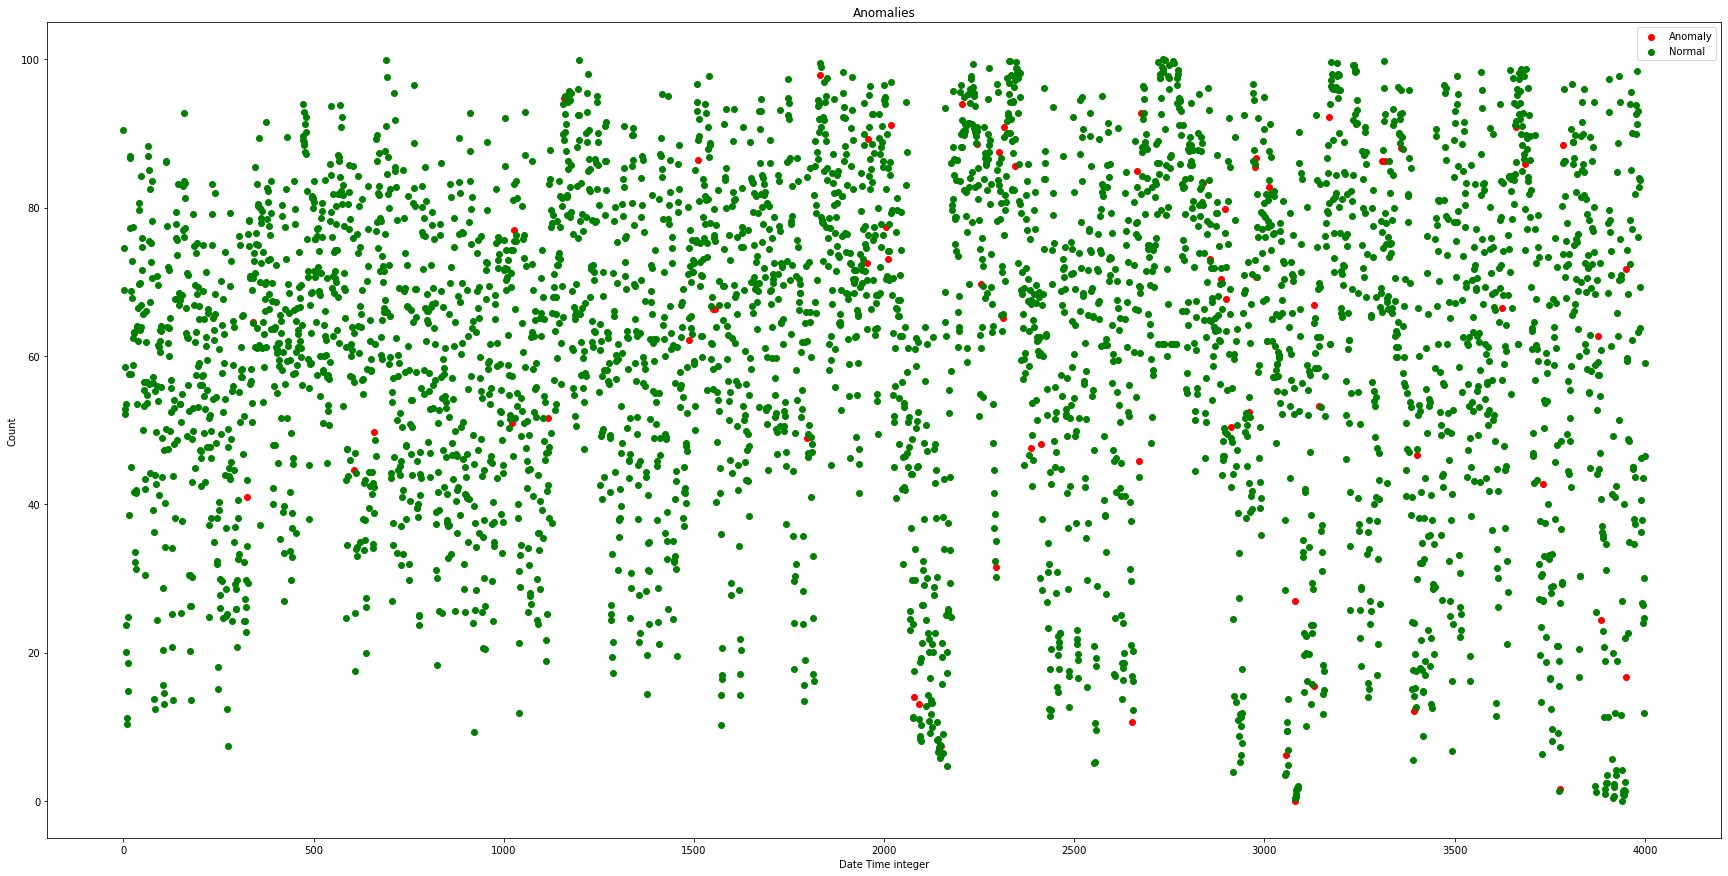

In [98]:
#red spots indicate where the anomalies were situated 

fig, ax = plt.subplots(figsize=(30, 15))
ax.scatter(anomalytrue.index, anomalytrue['OutboundUtilzation (%)'], color='red', label='Anomaly')
ax.scatter(anomalyfalse.index, anomalyfalse['OutboundUtilzation (%)'], color='green', label='Normal')
#ax.scatter(no_anomaly_df['SerialNo'], no_anomaly_df['cnt'], color='green', label='Normal')
plt.title('Anomalies')
plt.xlabel('Date Time integer')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
fig9 = px.line(bt, x='Timestamp', y='OutboundUtilzation (%)', title='Anomaly Analysis')


fig9.add_scatter(x=bt[bt['isAnomaly']==1]['Timestamp'],  y = bt[bt['isAnomaly']==1]['OutboundUtilzation (%)'],mode='markers')


fig9.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count=1, label='1d', step='day', stepmode='backward'),
            dict(count=2, label='1m', step='month', stepmode='backward'),
            dict(step='all')
        ])
    )
)


fig2 = px.line(bt, x='Timestamp', y='Score', title='Score')
fig3 = px.line(bt, x='Timestamp', y='OutboundUtilzation (%)', title='Outbound Utilization (%)')

fig9.show()
fig2.show()
fig3.show()